In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.datasets import mnist

## Autoencoder model

Autoencoders are an unsupervised learning technique in which we leverage neural networks for the task of representation learning. Specifically, we'll design a neural network architecture such that we impose a bottleneck in the network which forces a compressed knowledge representation of the original input.
![image.png](https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-06-at-3.17.13-PM.png)

### Encoder layer

In [2]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
    
    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return self.output_layer(activation)

### Decoder layer

In [3]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.relu)
  
    def call(self, code):
        activation = self.hidden_layer(code)
        return self.output_layer(activation)

### Build the autoencoder model

Chain the `encoder` and `decoder`

In [4]:
class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, original_dim):
    super(Autoencoder, self).__init__()
    self.loss = []
    self.encoder = Encoder(intermediate_dim=intermediate_dim)
    self.decoder = Decoder(intermediate_dim=intermediate_dim, original_dim=original_dim)

  def call(self, input_features):
    code = self.encoder(input_features)
    reconstructed = self.decoder(code)
    return reconstructed

As discussed above, the encoder's output is the input to the decoder, as it is written above (`reconstructed = self.decoder(code)`).

In [5]:
def loss(preds, real):
  return tf.reduce_mean(tf.square(tf.subtract(preds, real)))

## Forward pass and optimization

We will write a function for computing the forward pass, and applying a chosen optimization function.

In [6]:
def train(loss, model, opt, original):
  with tf.GradientTape() as tape:
    preds = model(original)
    reconstruction_error = loss(preds, original)
  gradients = tape.gradient(reconstruction_error, model.trainable_variables)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)
  
  return reconstruction_error

## The training loop

Finally, we will write a function to run the training loop. This function will take arguments for the model, the optimization function, the loss, the dataset, and the training epochs.

The training loop itself uses a `GradientTape` context defined in `train` for each batch.

In [7]:
def train_loop(model, opt, loss, dataset, epochs):
  for epoch in range(epochs):
    epoch_loss = 0
    for step, batch_features in enumerate(dataset):
      loss_values = train(loss, model, opt, batch_features)
      epoch_loss += loss_values
    model.loss.append(epoch_loss)
    print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

## Process the dataset

Now that we have defined our `Autoencoder` class, the loss function, and the training loop, let's import the dataset. We will normalize the pixel values for each example through dividing by maximum pixel value. We shall flatten the examples from 28 by 28 arrays to 784-dimensional vectors.

In [8]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train / 255.

x_train = x_train.astype(np.float32)
x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))

training_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(256)

11493376/11490434 [==============================] - 15s 1us/step


## Train the model

Now all we have to do is instantiate the autoencoder model and choose an optimization function, then pass the intermediate dimension and the original dimension of the images.

In [9]:
model = Autoencoder(intermediate_dim=128, original_dim=784)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(model, opt, loss, training_dataset, 20)

Epoch 1/20. Loss: 9.361982345581055
Epoch 2/20. Loss: 6.74198579788208
Epoch 3/20. Loss: 6.342862606048584
Epoch 4/20. Loss: 6.178501129150391
Epoch 5/20. Loss: 6.059024810791016
Epoch 6/20. Loss: 5.978312969207764
Epoch 7/20. Loss: 5.930237770080566
Epoch 8/20. Loss: 5.885005950927734
Epoch 9/20. Loss: 5.838245391845703
Epoch 10/20. Loss: 5.809695243835449
Epoch 11/20. Loss: 5.794317722320557
Epoch 12/20. Loss: 5.765193939208984
Epoch 13/20. Loss: 5.755937099456787
Epoch 14/20. Loss: 5.760085582733154
Epoch 15/20. Loss: 5.74103307723999
Epoch 16/20. Loss: 5.73280668258667
Epoch 17/20. Loss: 5.734768867492676
Epoch 18/20. Loss: 5.751086711883545
Epoch 19/20. Loss: 5.7318596839904785
Epoch 20/20. Loss: 5.710739612579346


## Plot the in-training performance

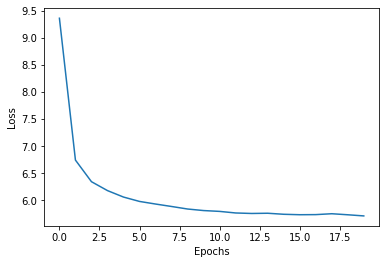

In [10]:
plt.plot(range(20), model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Predictions

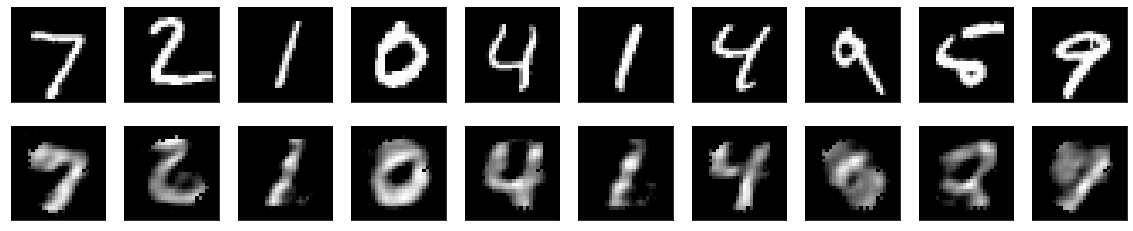

In [11]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()